In [1]:
from paretoKnapsackTeams import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

#Import datasets
#IMDB
imdb_experts_1, imdb_tasks_1, imdb_costs_1, imdb_graphmat_1 = import_pickled_datasets('imdb', 1)
imdb_experts_2, imdb_tasks_2, imdb_costs_2, imdb_graphmat_2 = import_pickled_datasets('imdb', 2)
# imdb_experts_3, imdb_tasks_3, imdb_costs_3, imdb_graphmat_3 = import_pickled_datasets('imdb', 3)

#Bibsonomy
bbsm_experts_1, bbsm_tasks_1, bbsm_costs_1, bbsm_graphmat_1 = import_pickled_datasets('bbsm', 1)
# bbsm_experts_2, bbsm_tasks_2, bbsm_costs_2, bbsm_graphmat_2 = import_pickled_datasets('bbsm', 2)
# bbsm_experts_3, bbsm_tasks_3, bbsm_costs_3, bbsm_graphmat_3 = import_pickled_datasets('bbsm', 3)

#Freelancer
fl_experts_1, fl_tasks_1, fl_costs_1, fl_graphmat_1 = import_pickled_datasets('freelancer', 1)
# fl_experts_2, fl_tasks_2, fl_costs_2, fl_graphmat_2 = import_pickled_datasets('freelancer', 2)

2026-01-25 23:30:37,520 |INFO: Imported imdb experts, Num Experts: 200
2026-01-25 23:30:37,521 |INFO: Imported imdb tasks, Num Tasks: 300
2026-01-25 23:30:37,522 |INFO: Imported imdb costs, Num Costs: 200
2026-01-25 23:30:37,525 |INFO: Imported imdb graph matrix, Shape: (1000, 1000)

2026-01-25 23:30:37,527 |INFO: Imported imdb experts, Num Experts: 400
2026-01-25 23:30:37,527 |INFO: Imported imdb tasks, Num Tasks: 300
2026-01-25 23:30:37,528 |INFO: Imported imdb costs, Num Costs: 400
2026-01-25 23:30:37,534 |INFO: Imported imdb graph matrix, Shape: (3000, 3000)

2026-01-25 23:30:37,535 |INFO: Imported bbsm experts, Num Experts: 250
2026-01-25 23:30:37,537 |INFO: Imported bbsm tasks, Num Tasks: 300
2026-01-25 23:30:37,537 |INFO: Imported bbsm costs, Num Costs: 250
2026-01-25 23:30:37,539 |INFO: Imported bbsm graph matrix, Shape: (500, 500)

2026-01-25 23:30:37,540 |INFO: Imported freelancer experts, Num Experts: 50
2026-01-25 23:30:37,541 |INFO: Imported freelancer tasks, Num Tasks: 25

### Average Plotting across Tasks

In [2]:
def findApproximateParetoSolutions(tasks_list, experts_list, costs_list,
                                   sizeUniverse, numExperts, numTasks, maxBudget,
                                   dataset_name=None):
    '''
    Run algorithms over multiple tasks, aggregate results, and plot mean +/- std.
    '''
    # Cost grid (same for all tasks)
    num_steps, min_cost = 15, 5
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    # algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-1", "ParetoGreedy-2"]
    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack"]

    def align_to_cost_arr(costs, covs):
        if len(costs) == 0:
            return np.zeros_like(cost_arr, dtype=float)
        costs = np.array(costs, dtype=float)
        covs = np.array(covs, dtype=float)
        return np.interp(cost_arr, costs, covs, left=covs[0], right=covs[-1])

    # containers across tasks
    all_coverages = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    # iterate tasks
    for task_index in range(numTasks):
        # per-task containers (will be appended to across budgets)
        imdb_coverages = {alg: [] for alg in algo_names}
        imdb_costs = {alg: [] for alg in algo_names}
        imdb_runtimes = {alg: [] for alg in algo_names}

        # pick random / provided costs for this run (keeps API similar)
        sampleCostVals = [i for i in range(5, 250, 20)]
        costs_list = [sampleCostVals[np.random.randint(low=0, high=len(sampleCostVals))] for _ in range(len(experts_list))]

        for budgetVal in cost_arr:
            # Initialize Pareto teams object
            paretoTeams = paretoKnapsackTeams(task=tasks_list[task_index],
                                         n_experts=experts_list[:numExperts],
                                         costs=costs_list, size_univ=sizeUniverse,
                                         budget=budgetVal)

            # Plain Greedy
            _, _, plainCov, plainCost, plainTime = paretoTeams.plainGreedy()
            imdb_coverages['PlainGreedy'].append(plainCov)
            imdb_costs['PlainGreedy'].append(plainCost)
            imdb_runtimes['PlainGreedy'].append(plainTime)

            # # Greedy Plus
            # # _, _, gpCov, gpCost, gpTime = paretoTeams.greedyPlus()
            # # imdb_coverages['GreedyPlus'].append(gpCov)
            # # imdb_costs['GreedyPlus'].append(gpCost)
            # # imdb_runtimes['GreedyPlus'].append(gpTime)

            # Two Guess Plain Greedy
            _, _, tgCov, tgCost, tgTime = paretoTeams.twoGuessPlainGreedy()
            imdb_coverages['PlainGreedy-2Guess'].append(tgCov)
            imdb_costs['PlainGreedy-2Guess'].append(tgCost)
            imdb_runtimes['PlainGreedy-2Guess'].append(tgTime)

            # One Guess Greedy Plus
            _, _, ogCov, ogCost, ogTime = paretoTeams.oneGuessGreedyPlus()
            imdb_coverages['GreedyPlus-1Guess'].append(ogCov)
            imdb_costs['GreedyPlus-1Guess'].append(ogCost)
            imdb_runtimes['GreedyPlus-1Guess'].append(ogTime)

        # Prefix Pareto (computed once per task at full budget)
        paretoTeams_full = paretoKnapsackTeams(task=tasks_list[task_index],
                                          n_experts=experts_list[:numExperts],
                                          costs=costs_list, size_univ=sizeUniverse,
                                          budget=maxBudget)
        pp1_costs, pp1_coverages, _, pp1_time = paretoTeams_full.prefixParetoGreedy_1Guess()
        # pp2_costs, pp2_coverages, _, pp2_time = paretoTeams_full.prefixParetoGreedy_2Guess()

        # Interpolate prefix pareto to the shared cost grid
        imdb_coverages['ParetoGreedy-Knapsack'] = list(align_to_cost_arr(pp1_costs, pp1_coverages))
        # imdb_coverages['ParetoGreedy-2'] = list(align_to_cost_arr(pp2_costs, pp2_coverages))
        imdb_runtimes['ParetoGreedy-Knapsack'].append(pp1_time)
        # imdb_runtimes['ParetoGreedy-2'].append(pp2_time)

        # convert per-task lists to numpy arrays and store in all_coverages
        for alg in algo_names:
            arr = np.array(imdb_coverages[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_coverages[alg].append(arr)
            runtimes = imdb_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    # compute mean and std across tasks for each algorithm
    mean_coverages = {}
    std_coverages = {}
    for alg in algo_names:
        stacked = np.vstack(all_coverages[alg])  # shape (numTasks, len(cost_arr))
        mean_coverages[alg] = np.mean(stacked, axis=0)
        std_coverages[alg] = np.std(stacked, axis=0)*0.5

    # Plot mean coverage with shaded std band
    colors = cm.viridis(np.linspace(0.05, 0.85, len(algo_names)))
    linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
    markers = ['o', 's', '^', 'v', 'D']

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_coverages[alg]
        std = std_coverages[alg]*0.5
        is_pareto = alg in {"ParetoGreedy-Knapsack", "ParetoGreedy-2"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'

        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-2":
            marker = "x"
            zorder = 5
        elif alg == "ParetoGreedy-Knapsack":
            marker = "D"
            zorder = 4

        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(cost_arr, mean,
                label=label,
                color=color,
                linestyle=line_style,
                marker=marker,
                markersize=marker_size,
                markeredgewidth=1.1,
                markeredgecolor='k',
                linewidth=1.8,
                zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, 1),
                        np.clip(mean + std, 0, 1),
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Team cost ($c_\ell$)', fontsize=24)
    ax.set_ylabel(r'Mean task coverage ($\bar{f}$)', fontsize=24)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=20)

    # Legend inside bottom right
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=16, frameon=True)

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

## Freelancer-1

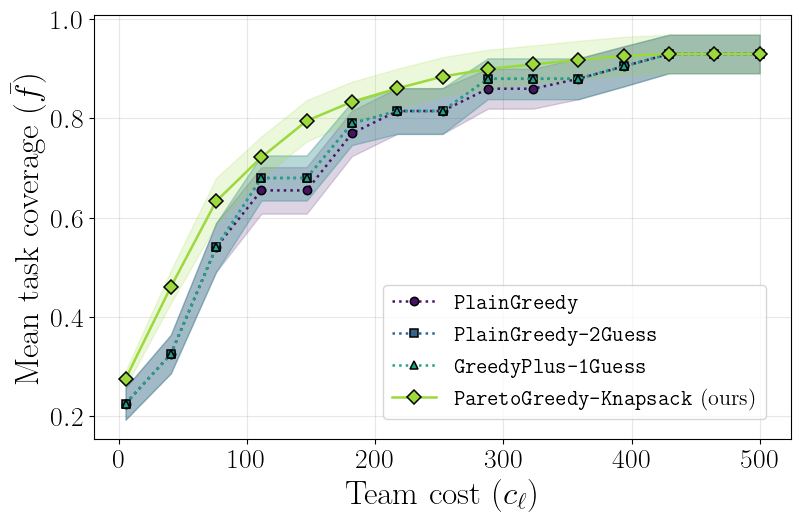

2026-01-25 23:30:50,805 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.002 ± 0.001
  - PlainGreedy-2Guess: 1.071 ± 0.368
  - GreedyPlus-1Guess: 0.170 ± 0.041
  - ParetoGreedy-Knapsack: 0.008 ± 0.003


In [3]:
findApproximateParetoSolutions(tasks_list=fl_tasks_1, experts_list=fl_experts_1, costs_list=fl_costs_1,
                               sizeUniverse=50, numExperts=50, numTasks=10, maxBudget=500,
                               dataset_name="Freelancer")

## IMDB

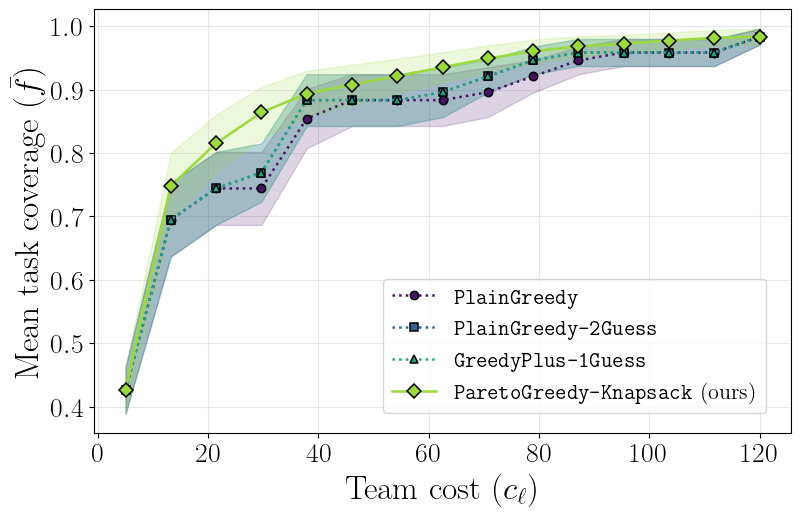

2026-01-25 23:30:55,266 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.006 ± 0.004
  - PlainGreedy-2Guess: 0.320 ± 0.081
  - GreedyPlus-1Guess: 0.077 ± 0.012
  - ParetoGreedy-Knapsack: 0.006 ± 0.004


In [4]:
findApproximateParetoSolutions(tasks_list=imdb_tasks_1, experts_list=imdb_experts_1, costs_list=imdb_costs_1,
                               sizeUniverse=24, numExperts=100, numTasks=10, maxBudget=120,
                               dataset_name="IMDB-1")

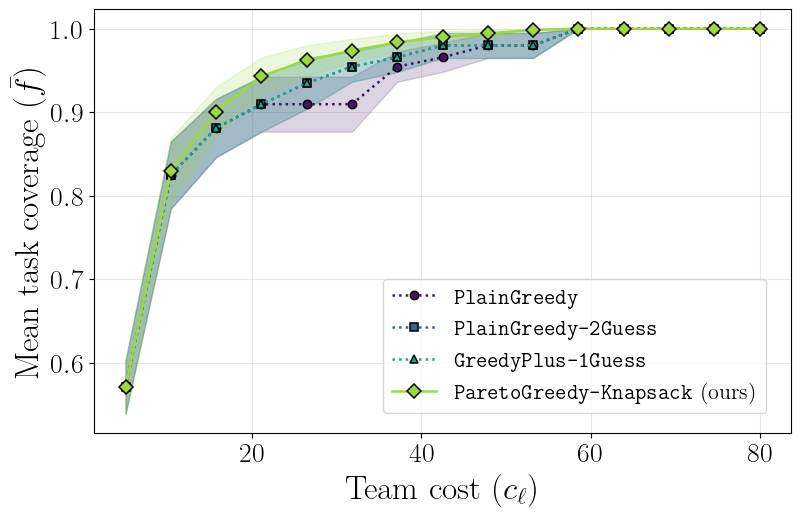

2026-01-25 23:31:00,743 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.007 ± 0.004
  - PlainGreedy-2Guess: 0.427 ± 0.134
  - GreedyPlus-1Guess: 0.078 ± 0.028
  - ParetoGreedy-Knapsack: 0.004 ± 0.002


In [5]:
findApproximateParetoSolutions(tasks_list=imdb_tasks_2, experts_list=imdb_experts_2, costs_list=imdb_costs_2,
                               sizeUniverse=24, numExperts=150, numTasks=10, maxBudget=80,
                               dataset_name="IMDB-2")

## Bbsm-1

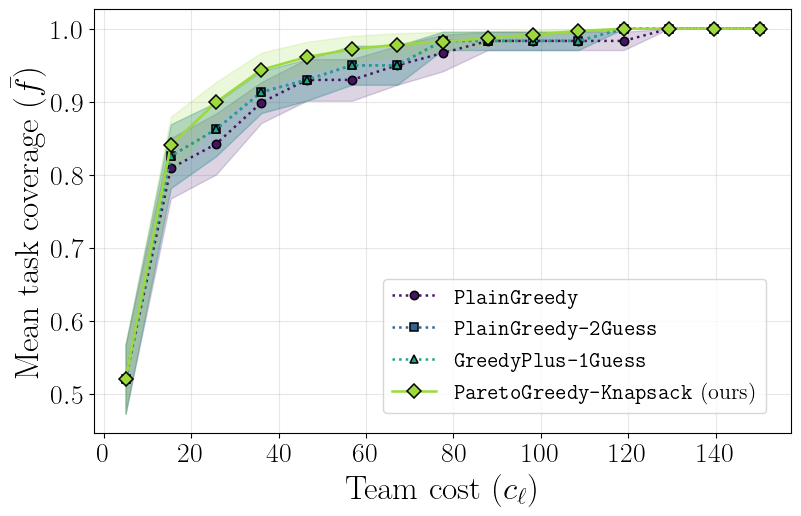

2026-01-25 23:31:22,898 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.009 ± 0.005
  - PlainGreedy-2Guess: 1.837 ± 0.422
  - GreedyPlus-1Guess: 0.308 ± 0.071
  - ParetoGreedy-Knapsack: 0.021 ± 0.005


In [6]:
findApproximateParetoSolutions(tasks_list=bbsm_tasks_1, experts_list=bbsm_experts_1, costs_list=bbsm_costs_1,
                               sizeUniverse=75, numExperts=150, numTasks=10, maxBudget=150,
                               dataset_name="Bbsm")